In [5]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset
import torchvision as tv

import os, sys
import numpy as np
import pickle
from PIL import Image
import math
from tqdm import tqdm

from matplotlib import pyplot as plt

from sklearn.metrics import roc_auc_score

# from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, cosine_distances

from model_old import ImageEncoder_Classification
# from transformers import BertConfig

from misc.config_iu import Config
cfg  = Config()
cfg.GPU_ID = 2

torch.cuda.set_device(cfg.GPU_ID)

In [2]:
data_dir = cfg.dataset_root # ''
img_dir = os.path.join(data_dir, 'images', 'images_normalized')
with open('../dataset/cleaned_dataset_v2.pickle','rb') as f:
    dataset = pickle.load(f)

In [3]:
dataset.keys()

dict_keys(['data_dict', 'data_split', 'word2idx', 'idx2word', 'classes'])

In [4]:
dataset['data_split'].keys()

dict_keys(['train_uids', 'val_uids', 'test_uids'])

In [5]:
np.array(dataset['data_dict'][3750])

array({'filenames': ['3750_IM-1874-1001.dcm.png'], 'text': 'there is stable cardiomegaly. right pleural effusion is slightly increased in size. pulmonary vasculature is persistently enlarged. prominent interstitium is stable. no  focal infiltrate. no pneumothorax. visualized osseous structures intact.', 'split': 0, 'token_ids': [1, 4, 5, 152, 333, 79, 9, 10, 5, 354, 556, 107, 83, 54, 55, 5, 1533, 267, 379, 2066, 5, 152, 6, 7, 810, 6, 12, 171, 116, 117, 118, 2]},
      dtype=object)

In [6]:
dataset['classes'][3750]

['edema', 'cardiomegaly', 'effusion']

In [3]:
imgfile = os.path.join('../dataset/images/images_normalized', dataset['data_dict'][3750]['filenames'][0])
img = Image.open(imgfile)

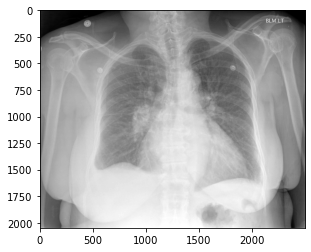

In [6]:
plt.imshow(img, cmap='gray')

In [45]:
' '.join([dataset['idx2word'][x] for x in dataset['data_dict'][3750]['token_ids']])

'[CLS] there is stable cardiomegaly right pleural effusion is slightly increased in size pulmonary vasculature is persistently enlarged prominent interstitium is stable no focal infiltrate no pneumothorax visualized osseous structures intact [SEP]'

In [38]:
class_to_idx = {
    'Atelectasis': 0, 'Cardiomegaly': 1, 'Consolidation': 2, 'Edema': 3, 'Enlarged Cardiomediastinum': 4, 
    'Fracture': 5, 'Lung Lesion': 6, 'Lung Opacity': 7, 'No Finding': 8, 'Pleural Effusion': 9, 
    'Pleural Other': 10, 'Pneumonia': 11, 'Pneumothorax': 12, 'Support Devices': 13
}

idx_to_class = {
    0:'Atelectasis', 1:'Cardiomegaly', 2:'Consolidation', 3:'Edema', 4:'Enlarged Cardiomediastinum', 
    5:'Fracture', 6:'Lung Lesion', 7:'Lung Opacity', 8:'No Finding', 9:'Pleural Effusion', 
    10:'Pleural Other', 11:'Pneumonia', 12:'Pneumothorax', 13:'Support Devices'
}

iu_cls = {'no finding':8
            ,'edema':3
            ,'consolidation':2
            ,'pneumonia':11
            ,'pneumothorax':12
            ,'atelectasis':0
            ,'cardiomegaly':1
            ,'effusion':9}

iu_idx = {0:'atelectasis'
            ,1:'cardiomegaly'
            ,9:'effusion'
            ,3:'edema'
            ,2:'consolidation'
            ,11:'pneumonia'
            ,12:'pneumothorax'
            ,8:'no finding'}

In [40]:
## check the corresponding labels of MIMIC and OPENI
for i in range(14):
    try: 
        print('%02d --> mimic: %02d %s, openi: %02d %s' % (i, class_to_idx[idx_to_class[i]], idx_to_class[i], iu_cls[iu_idx[i]], iu_idx[i]))
    except Exception:
        print('%02d --> not common class.')

00 --> mimic: 00 Atelectasis, openi: 00 atelectasis
01 --> mimic: 01 Cardiomegaly, openi: 01 cardiomegaly
02 --> mimic: 02 Consolidation, openi: 02 consolidation
03 --> mimic: 03 Edema, openi: 03 edema
%02d --> not common class.
%02d --> not common class.
%02d --> not common class.
%02d --> not common class.
08 --> mimic: 08 No Finding, openi: 08 no finding
09 --> mimic: 09 Pleural Effusion, openi: 09 effusion
%02d --> not common class.
11 --> mimic: 11 Pneumonia, openi: 11 pneumonia
12 --> mimic: 12 Pneumothorax, openi: 12 pneumothorax
%02d --> not common class.


In [41]:
MAX_DIM = 2048

# train_transform = tv.transforms.Compose([
#     tv.transforms.RandomRotation(15), # rotation will cost 0.1s for each 10 images
#     tv.transforms.RandomCrop(MAX_DIM, pad_if_needed=True), # 0.6s for each 10 images
#     tv.transforms.ColorJitter(brightness=[0.5, 1.8] # colorjitter will cost 0.32s for each 10 images
#                               , contrast=[0.5, 1.8]
#                               , saturation=[0.5, 1.8]),
#     tv.transforms.ToTensor(), 
#     tv.transforms.Normalize(0.5, 0.5)
# ])

val_transform = tv.transforms.Compose([
    tv.transforms.CenterCrop(MAX_DIM),
    tv.transforms.ToTensor(),  
    tv.transforms.Normalize(0.5, 0.5)
])

class IUDataset(Dataset):
    def __init__(self, root, dataset, max_length, transform=val_transform, mode='test'):
        super().__init__()
        
        self.root = root #save dir
        self.transform = transform
        self.mode = mode

        self.classes = dataset['classes'] # multi-label list
        self.datadict = dataset['data_dict'] # uid: {text:text, filenames:[filename]}
        if self.mode == 'test':
            self.keys = np.concatenate([dataset['data_split']['train_uids'], dataset['data_split']['val_uids'], dataset['data_split']['test_uids']]) # uid list
#         elif self.mode == 'val':
#             self.keys = np.concatenate([dataset['split']['val1'], dataset['split']['val2']]) # uid list
#         elif self.mode == 'test':
#             self.keys = dataset['split']['test'] # uid list

#         self.class_to_idx = {
#             'Atelectasis': 0, 'Cardiomegaly': 1, 'Consolidation': 2, 'Edema': 3, 'Enlarged Cardiomediastinum': 4, 
#             'Fracture': 5, 'Lung Lesion': 6, 'Lung Opacity': 7, 'No Finding': 8, 'Pleural Effusion': 9, 
#             'Pleural Other': 10, 'Pneumonia': 11, 'Pneumothorax': 12, 'Support Devices': 13
#         }
        
#         self.idx_to_class = {
#             0:'Atelectasis', 1:'Cardiomegaly', 2:'Consolidation', 3:'Edema', 4:'Enlarged Cardiomediastinum', 
#             5:'Fracture', 6:'Lung Lesion', 7:'Lung Opacity', 8:'No Finding', 9:'Pleural Effusion', 
#             10:'Pleural Other', 11:'Pneumonia', 12:'Pneumothorax', 13:'Support Devices'
#         }

            
        self.class_to_idx = {'no finding':8
                            ,'edema':3
                            ,'consolidation':2
                            ,'pneumonia':11
                            ,'pneumothorax':12
                            ,'atelectasis':0
                            ,'cardiomegaly':1
                            ,'effusion':9}
        
        self.idx_to_class = {0:'atelectasis'
                             ,1:'cardiomegaly'
                             ,9:'effusion'
                             ,3:'edema'
                             ,2:'consolidation'
                             ,11:'pneumonia'
                             ,12:'pneumothorax'
                             ,8:'no finding'}
        
        self.num_classes = 14

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        uid = self.keys[idx]
        
        image_id = np.random.choice(self.datadict[uid]['filenames'])# get one file name randomly
        image_path = os.path.join(self.root, image_id) #original used 'jpg', try 'png'

        try:
            with Image.open(image_path) as img:
                if self.transform:
                    image = self.transform(img)

        except Exception as ex:
            print(ex)
#             with open(self.err_log, 'a+') as f:
#                 f.write('%s\nERR_IMG %s\n' % (ex, image_path))
            return None ## return None, collate_fn will ignore this broken sample
        
        classes = torch.tensor([self.class_to_idx[x] for x in self.classes[uid]])
        y_onehot = torch.FloatTensor(self.num_classes).zero_()
        y_onehot.scatter_(0, classes, 1)
        
        return image, y_onehot, uid
        

def build_dataset(mode='test', cfg=None):
    data_dir = cfg.dataset_root
    img_dir = os.path.join(data_dir, 'images', 'images_normalized')
    with open(os.path.join(data_dir, 'cleaned_dataset_v2.pickle'), 'rb') as f:
        dataset = pickle.load(f)
    if mode == 'test':
        data = IUDataset(img_dir, dataset, 
                               max_length=cfg.max_length, mode=mode, 
                               transform=val_transform)
        return data

#     elif mode == 'val':
#         data = MimicDataset(img_dir, dataset, 
#                                max_length=cfg.max_length, mode=mode, 
#                                transform=val_transform)
#         return data
    
#     elif mode == 'test':
#         data = MimicDataset(img_dir, dataset, 
#                                max_length=cfg.max_length, mode=mode, 
#                                transform=val_transform)
#         return data

    else:
        raise NotImplementedError(f"{mode} not supported")
        
## collate_fn for handling None type item due to image corruption ##
## This will return batch size - broken image number ##
def collate_fn_ignore_none(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

In [110]:
# test_set = build_dataset('val', cfg)
test_set = build_dataset('test', cfg)
print('Testing set %d is loaded.' % len(test_set))
test_loader = torch.utils.data.DataLoader(
                test_set, batch_size=50, 
                collate_fn=collate_fn_ignore_none, drop_last=False,
                shuffle=False, num_workers=2, pin_memory=False)
# print('Vocab size is %d.' % test_set.vocab_size)

Testing set 3666 is loaded.


In [43]:
it = iter(test_loader)
image, text, uids = it.next()

In [44]:
for i in range(len(uids)):
    print('%04d: ' % uids[i], text[i])

2034:  tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1661:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
1800:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
0161:  tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
3492:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
2424:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
2081:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
0568:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
2005:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
1130:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
0695:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
3460:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
0312:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
1758:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0

In [37]:
dataset['classes'][3750]

['edema', 'cardiomegaly', 'effusion']

In [117]:
##### change the checkpoint path here #####
# raw checkpoint: '/media/My1TBSSD1/IPMI2021/output/MIMIC_class_raw_2020_12_09_22_17_55/Model/image_encoder25.pth'
# fz checkpoint: '/media/My1TBSSD1/IPMI2021/pretrained/image_encoder14.pth'
# ft checkpoint: '/media/My1TBSSD1/IPMI2021/output/MIMIC_class_ft_2020_12_11_09_18_56/Model/image_encoder12.pth'
cfg.text_encoder_path = '../output/MIMIC_class_raw_2020_12_09_22_17_55/Model/image_encoder19.pth'
# ################### encoders ################################# #      
image_encoder = ImageEncoder_Classification(num_class=14, encoder_path='', pretrained=False, cfg = cfg)

if cfg.CUDA:
    image_encoder = image_encoder.cuda()
    
if cfg.text_encoder_path != '':
    img_encoder_path = cfg.text_encoder_path.replace('text_encoder', 'image_encoder')
    print('Load image encoder checkpoint from:', img_encoder_path)
    state_dict = torch.load(img_encoder_path, map_location='cpu')
    image_encoder.load_state_dict(state_dict['model'])


Load image encoder checkpoint from: /media/My1TBSSD1/IPMI2021/output/MIMIC_class_raw_2020_12_09_22_17_55/Model/image_encoder19.pth


In [111]:
@torch.no_grad()
def evaluate(cnn_model, dataloader_val):
    cnn_model.eval()
    val_data_iter = iter(dataloader_val)
    y_preds = []
    y_trues = []
    class_auc = []
    #####################################
    ## label reflaction: [0,1,2,3,8,9,11,12]
    for step in tqdm(range(len(val_data_iter))):  
        real_imgs, classes, uids = val_data_iter.next()
        if cfg.CUDA:
            real_imgs, classes = real_imgs.cuda(), classes.cuda()

        y_pred = cnn_model(real_imgs)
        y_pred_sigmoid = torch.sigmoid(y_pred)
        y_preds.append(y_pred_sigmoid.detach().cpu().numpy())
        y_trues.append(classes.detach().cpu().numpy())
        
#         break

    y_preds = np.concatenate(y_preds,axis=0)
    y_trues = np.concatenate(y_trues,axis=0)
#     print(y_preds.shape, y_trues.shape)
#     for i in range(y_preds.shape[-1]):
    for i in [0,1,2,3,8,9,11,12]:
        class_auc.append(roc_auc_score(y_trues[:,i],y_preds[:,i]))

    return class_auc

In [118]:
auc = evaluate(image_encoder, test_loader)

100%|██████████| 74/74 [01:45<00:00,  1.43s/it]


In [119]:
openi_cls = [0,1,2,3,8,9,11,12]

for idx in range(len(auc)):
    print('%s: %.4f' % (test_loader.dataset.idx_to_class[openi_cls[idx]], auc[idx]))

avg= np.mean(auc)
print('Avg: %.4f' % avg)

weight = np.array([295, 319, 28, 41, 2988, 141, 36, 25]) # weight for the whole open-i dataset
weight = weight / weight.sum()
wavg = np.array(auc) @ weight
print('wAvg: %.4f' % wavg)

atelectasis: 0.8292
cardiomegaly: 0.9238
consolidation: 0.9511
edema: 0.9367
no finding: 0.8435
effusion: 0.9377
pneumonia: 0.8626
pneumothorax: 0.9265
Avg: 0.9014
wAvg: 0.8550


In [12]:
### should remove 'No Findings' score when calculating Avg or wAvg

# atelectasis: 0.8577
# cardiomegaly: 0.9371
# consolidation: 0.9513
# edema: 0.9526
# no finding: 0.8507
# effusion: 0.9573
# pneumonia: 0.9341
# pneumothorax: 0.9356

sc = np.array([0.8577,
                0.9371,
                0.9513,
                0.9526,
                0.9573,
                0.9341,
                0.9356])
wt = np.array([295, 319, 28, 41, 141, 36, 25])
mn = sc.mean()
wmn = sc @ wt / wt.sum()
print(mn, wmn)

0.9322428571428573 0.9148545762711864


In [120]:
for i in [295, 319, 28, 41, 2988, 141, 36, 25]:
    print(i)

295
319
28
41
2988
141
36
25


## split

In [80]:
## statistic for val sets and test sets
# hold = np.array([679, 808, 191, 659, 132, 78, 108, 974, 539, 990, 52, 309, 94, 1061])
# val1 = np.array([392, 422, 102, 246, 64, 46, 63, 484, 619, 533, 19, 134, 110, 685])
# val2 = np.array([566, 575, 131, 354, 110, 33, 105, 650, 1017, 710, 12, 227, 124, 881])
# print(list((val1+val2)))

In [55]:
dataset.keys()

dict_keys(['data_dict', 'data_split', 'word2idx', 'idx2word', 'classes'])

In [57]:
# class_to_idx = {
#     'Atelectasis': 0, 'Cardiomegaly': 1, 'Consolidation': 2, 'Edema': 3, 'Enlarged Cardiomediastinum': 4, 
#     'Fracture': 5, 'Lung Lesion': 6, 'Lung Opacity': 7, 'No Finding': 8, 'Pleural Effusion': 9, 
#     'Pleural Other': 10, 'Pneumonia': 11, 'Pneumothorax': 12, 'Support Devices': 13
# }

# idx_to_class = {
#     0:'Atelectasis', 1:'Cardiomegaly', 2:'Consolidation', 3:'Edema', 4:'Enlarged Cardiomediastinum', 
#     5:'Fracture', 6:'Lung Lesion', 7:'Lung Opacity', 8:'No Finding', 9:'Pleural Effusion', 
#     10:'Pleural Other', 11:'Pneumonia', 12:'Pneumothorax', 13:'Support Devices'
# }

class_to_idx = {'no finding':8
            ,'edema':3
            ,'consolidation':2
            ,'pneumonia':11
            ,'pneumothorax':12
            ,'atelectasis':0
            ,'cardiomegaly':1
            ,'effusion':9}

idx_to_class = {0:'atelectasis'
            ,1:'cardiomegaly'
            ,9:'effusion'
            ,3:'edema'
            ,2:'consolidation'
            ,11:'pneumonia'
            ,12:'pneumothorax'
            ,8:'no finding'}

In [76]:
full = []
for uid in dataset['data_dict'].keys():
    classes = torch.tensor([class_to_idx[x] for x in dataset['classes'][uid]])
    y_onehot = torch.FloatTensor(14).zero_()
    y_onehot.scatter_(0, classes, 1)
    full.append((y_onehot.unsqueeze(0).numpy()))

In [77]:
full = np.concatenate(full, axis=0)

In [79]:
full.sum(0)

array([ 295.,  319.,   28.,   41.,    0.,    0.,    0.,    0., 2988.,
        141.,    0.,   36.,   25.,    0.], dtype=float32)